<a href="https://colab.research.google.com/github/KozinIS/CV/blob/main/04_%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B7%D0%B0%D1%80%D0%BF%D0%BB%D0%B0%D1%82%D1%8B_%D0%BF%D0%BE_%D1%80%D0%B5%D0%B7%D1%8E%D0%BC%D0%B5_(DNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Предсказание зарплаты по резюме (DNN)**

# 1 Постановка задачи

*Подготовьте составную нейронную сеть, предназначенную для предсказания размера заработной платы по резюме. Нейронная сеть должна учитывать различные типы данных (цифровые, текстовые). Для формирования обучающей выборки необходимо использовать базу hh.ru (прилагается к заданию).*

# 2 Подгрузка библиотек и подключение диска

In [ ]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model #
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Embedding, Flatten, Activation
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler #
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел
import math # Для округления
#import os #Для работы с файлами
import re #
import matplotlib.pyplot as plt #
%matplotlib inline

from IPython.display import clear_output

In [ ]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Mounted at /content/drive


# 3 Подгрузка базы

In [ ]:
fixed_df = pd.read_csv('/content/drive/My Drive/HW_19/hh_fixed.csv')# Это то, куда вы скачали файл

In [ ]:
print(fixed_df.shape)

(62967, 13)


In [ ]:
fixed_df.head() #Показываем пример данных (первые 6 колонок)

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано
3,3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль
4,4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано


In [ ]:
# Пример данных
n = 0 # Берем первое резюме
for i in range(len(fixed_df.values[n])): # Выводим значение каждой графы резюме
  print(i, " ", fixed_df.values[n][i])

0   0
1   Мужчина ,  29 лет , родился 16 мая 1989
2   40000 руб.
3   Специалист по поддержке чата(support team) домашний агент
4   Новороссийск , готов к переезду (Анапа, Геленджик) , не готов к командировкам
5   полная занятость
6   полный день
7   Опыт работы 3 года 9 месяцев  Специалист по поддержке чата(support team) домашний агент 40 000 руб. Информационные технологии, интернет, телеком Системный администратор Сотовые, Беспроводные технологии Телекоммуникации Занятость: полная занятость График работы: полный день Опыт работы 3 года 9 месяцев Май 2012 — Январь  2016 3 года 9 месяцев ООО "Гольфстрим" Республика Башкортостан Строительство, недвижимость, эксплуатация, проектирование ... Строительство жилищное Управление и эксплуатация недвижимости Генеральный директор Руководство, отладка деловых связей, заключение договоров, развитие организации Ключевые навыки Теперь резюме открыто всему интернету — изменить можно в настройках видимости. Заключение договоров Деловое общение Деловая 

# 4 Парсинг базы

In [ ]:
##############################################
####Убрать кодировку в описаниях \xa0 \n
##############################################
fixed_df = fixed_df.drop(fixed_df.columns[0],axis = 1) # Убираем первый столбец с продублированными индексами. Он нам не нужен

i=0
for j in range(12):  # Для каждого из столбцов таблицы
    for i in range(fixed_df.shape[0]): # По всем резюме
        if type(fixed_df.values[i][j])!=float: # если данные текстовые, то заменяем фрагменты кодировки ASCII на отсутствие символов
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\xa0","")
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\n"," ")

In [ ]:
# Данные о поле и возрасте
def getParameterSexAge(arg):
  out = [0,0]
  #Если М, то 1. По умолчанию 0 - Ж
  if "М" in arg:
    out[0] = 1
  # текущий год - год рождения
  year_tec = 2020
  if (len(arg) > 7):
    out[1] = year_tec - int(re.findall(r'\d{4}', arg)[0])
  return out

# Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
  outClass =int((arg-13)/5)
  outClass = max(0, min(10,outClass))
  # На выходе получаем вектор с нужной категорией возраста
  return list(utils.to_categorical(outClass, 11).astype('int'))


# Зарплата
def getParameterSalary(arg):
    num = arg
    # Сначала получаем чистое число, убираем лишние знаки
    if (type(num) == str):
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')

        # Получаем чисто валюту, убираем цифры
        curr = re.sub('[0-9]','',arg)
        curr = curr.replace('.','').strip()

        # Конвертируем в рубли, если валюта
        if curr == 'USD':
           num = float(num)*65
        elif curr == 'KZT':
           num = float(num)*0.17
        elif curr=='грн':
           num = float(num)*2.6
        elif curr=='белруб':
           num = float(num)*30.5
        elif curr=='EUR':
           num = float(num)*70
        elif curr=='KGS':
           num = float(num)*0.9
        elif curr=='сум':
           num = float(num)*0.007
        elif curr=='AZN':
           num = float(num)*37.5

    salaryStr = int(num)


    return salaryStr


# Данные о городе
def getParameterCity(arg):
  millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  sarg=arg.split(',')
  for item in sarg:
    item= item.strip()
    if item == "Москва":          return [1, 0, 0, 0]
    if item == "Санкт-Петербург": return [0, 1, 0, 0]
    if item in millionCities:     return [0, 0, 1, 0]
  return [0, 0, 0, 1]

# Данные о желаемой занятости
def getParameterEmployment(arg):
  out= [0, 0, 0, 0]
  if ("стажировка" in arg):           out[0]=1
  if ("частичная занятость" in arg):  out[1]=1
  if ("проектная работа" in arg):     out[2]=1
  if ("полная занятость" in arg):     out[3]=1
  return out

# Данные о желаемом графике работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0]
  if ("гибкий график" in arg):    out[0]=1
  if ("полный день" in arg):      out[1]=1
  if ("сменный график" in arg):   out[2]=1
  if ("удаленная работа" in arg): out[3]=1
  return out

# Данные об образовании
def getParameterEducation(arg):
  out = [0, 0, 0, 0] #По умолчанию не указано
  if arg in "Высшее Higher education":  out[0] = 1
  if arg in "Среднее специальное":      out[1] = 1
  if arg in "Неоконченное высшее":      out[2] = 1
  if arg in "Среднее образование":      out[3] = 1
  return out

# Данные об опыте работы
def getParameterExperience(arg):
  arg = str(arg)
  #Проверяем, если не пустая строка
  symbols = 0
  years = 0
  months = 0
  for s in arg:
    if (s != " "):
      symbols += 1

  #Находим индексы пробелов около фразы "опыт работы"
  if (symbols > 10):
      spacesIndexes = []
      index = 0
      while ((len(spacesIndexes) < 5) & (index < len(arg))):
          if (arg[index] == " "):
              spacesIndexes.append(index)
          index += 1

      years = 0
      months = 0
      if (arg[spacesIndexes[2]+1] != "м"):
         if (len(spacesIndexes) >= 3):
            yearsStr = arg[spacesIndexes[1]:spacesIndexes[2]] # Записываем в строку значение лет
            years = int(yearsStr)

         if (len(spacesIndexes) >= 5):
            monthsStr = arg[spacesIndexes[3]:spacesIndexes[4]] # Записываем в строку значение месяцев
            if(arg[spacesIndexes[2]+1] == "м"):
                months = int(monthsStr)
      else:
        if (len(spacesIndexes) >= 3):
          monthsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
          months = int(monthsStr)

  return 12*years+months

# Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = getParameterExperience(arg)
  outClass = 0
  if (out > 6): # если больше 6 месяцев
    outClass = 1
  if (out > 12): # если больше 12 месяцев
    outClass = 2
  if (out > 24): # если больше 24 месяцев
    outClass = 3
  if (out > 36): # если больше 36 месяцев
    outClass = 4
  if (out > 60): # если больше 60 месяцев
    outClass = 5
  if (out > 96): # если больше 96 месяцев
    outClass = 6
  if (out > 120): # если больше 120 месяцев
    outClass = 7
  if (out > 156): # если больше 156 месяцев
    outClass = 8
  if (out > 192): # если больше 192 месяцев
    outClass = 9
  if (out > 240): # если больше 240 месяцев
    outClass = 10

  return list(utils.to_categorical(outClass, 11).astype('int'))

# Извлекаем все параметры
def getAllParameters(val):
  result = getParameterSexAge(val[0])
  sex = result[0]  #getParameterSex() #параметры о поле
  age =getParameterAgeVect(result[1]) #параметры о возрасте
  city = getParameterCity(val[3]) #параметры о городе
  employment = getParameterEmployment(val[4]) #параметры о желаемой занятости
  shedule = getParameterSchedule(val[5]) #параметры о желаемом графике
  education = getParameterEducation(val[9]) #параметры об образовании
  experience = getParameterExperienceVector(val[6]) #параметры об опыте
  out = []

# Склеиваем все параметры в вектор
  out.append(sex)
  out += age
  out += city
  out += employment
  out += shedule
  out += education
  out += experience

  return out

# 5 Создание тренеровчной выборки для нейросети № 1 (в т.ч. общего yTrain)

*(пол, возраст, город, занятость, график, образование, опыт (лет, месяцев))*

In [ ]:
# Создаем тренировочную выборку
def get01Data(values):
  xTrain = []
  yTrain = []

  # Предсказывать будем зарплату
  for val in values:
    y = getParameterSalary(val[1])

    # Все, что не зарплата - обучающая выборка
    if (y != -1):
      x = getAllParameters(val)
      xTrain.append(x)
      yTrain.append(y/1000)

  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)


  return (xTrain, yTrain)

In [ ]:
(xTrain01, yTrain) = get01Data(fixed_df.values) # Извлекаем значения загруженного набора данных

In [ ]:
# Размер набора параметров и зарплат
print(xTrain01.shape)
print(yTrain.shape)
# Пример обработанных данных
n = 0
print(xTrain01[n])
print(yTrain[n])

(62967, 39)
(62967,)
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0]
40.0


# 6 Эксперименты с нейросетью № 1

Epoch 1/50
152/152 - 1s - loss: 25776.9180 - mae: 61.2413 - val_loss: 4979.2642 - val_mae: 39.4823
Epoch 2/50
152/152 - 1s - loss: 21920.4590 - mae: 42.3173 - val_loss: 3682.4109 - val_mae: 33.1697
Epoch 3/50
152/152 - 0s - loss: 21518.6523 - mae: 39.8288 - val_loss: 3308.1958 - val_mae: 31.9942
Epoch 4/50
152/152 - 0s - loss: 21387.0137 - mae: 38.7647 - val_loss: 3124.2700 - val_mae: 31.8202
Epoch 5/50
152/152 - 1s - loss: 21306.2051 - mae: 38.6238 - val_loss: 3108.6750 - val_mae: 31.6496
Epoch 6/50
152/152 - 1s - loss: 21354.5293 - mae: 38.3994 - val_loss: 3108.7954 - val_mae: 31.5683
Epoch 7/50
152/152 - 1s - loss: 21302.7910 - mae: 38.4900 - val_loss: 3051.3787 - val_mae: 31.5623
Epoch 8/50
152/152 - 0s - loss: 21293.6309 - mae: 38.5250 - val_loss: 3075.4082 - val_mae: 31.4324
Epoch 9/50
152/152 - 1s - loss: 21376.8613 - mae: 38.3967 - val_loss: 3063.7783 - val_mae: 31.3727
Epoch 10/50
152/152 - 0s - loss: 21244.8262 - mae: 38.4313 - val_loss: 3073.0437 - val_mae: 31.3147
Epoch 11/

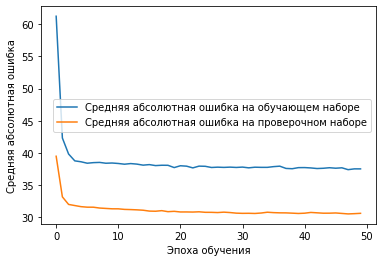

In [ ]:
# Обучаем модель полученными данными
model = Sequential()
model.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))      # был relu


model.add(Dense(256, activation='linear'))      # Лучшее кол-во (тангенс ,был, сделал linear)
model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='linear'))    # linear

model.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])

history = model.fit(xTrain01,
                    yTrain,
                    epochs=50,
                    batch_size=250,
                    validation_split=0.4,
                    verbose=2)

plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

# 7 Создание тренеровчной выборки для нейросети № 2

*(последняя должнотсь)*

In [ ]:
# Выкачиваем данные по профессиям
def getXTrainTProf(values):
  xTrainTProf = []

  for val in values:
    currText = ""
    if (type(val[2]) != float):
      currText += val[2]
    if (type(val[7]) != float):
      currText += " " + val[7]

    if (getParameterSalary(val[1]) != -1): # Проверяем, если есть данные о зарплате
      xTrainTProf.append(currText)

  xTrainTProf = np.array(xTrainTProf)

  return xTrainTProf

In [ ]:
# Вытаскиваем професии для выборки
xTrainTProf = getXTrainTProf(fixed_df.values)
print(xTrainTProf[123]) # пример профессии 11го резюме

Аналитик Комсомольская правда, ИД


In [ ]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 10000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainTProf) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра

In [ ]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainProfIndexes = tokenizer.texts_to_sequences(xTrainTProf) #обучающие тесты в индексы

In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrainProf01 = tokenizer.sequences_to_matrix(xTrainProfIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainProf01.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01[0][0:100])

(62967, 10000)
[0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 0
print(xTrainTProf[n])       # Профессия
print(xTrainProfIndexes[n]) # Профессия через индексы

Специалист по поддержке чата(support team) домашний агент ООО "Гольфстрим"
[4, 5, 219, 2300, 402, 139, 2976, 2006, 2, 1613]


In [ ]:
xTrainProf01.shape

(62967, 10000)

# 8 Эксперименты с нейросетью № 2

Epoch 1/50
2500/2500 [==============================] - 7s 3ms/step - loss: 16033.3047 - mae: 30.3578 - val_loss: 1920.9639 - val_mae: 28.2306
Epoch 2/50
2500/2500 [==============================] - 7s 3ms/step - loss: 15228.0195 - mae: 24.2361 - val_loss: 1728.4047 - val_mae: 25.7088
Epoch 3/50
2500/2500 [==============================] - 7s 3ms/step - loss: 14669.1250 - mae: 20.1490 - val_loss: 1661.0970 - val_mae: 25.3424
Epoch 4/50
2500/2500 [==============================] - 7s 3ms/step - loss: 14184.9062 - mae: 18.1963 - val_loss: 1594.8264 - val_mae: 24.4526
Epoch 5/50
2500/2500 [==============================] - 7s 3ms/step - loss: 13851.4355 - mae: 15.8942 - val_loss: 1856.6637 - val_mae: 26.7934
Epoch 6/50
2500/2500 [==============================] - 7s 3ms/step - loss: 13114.1514 - mae: 15.1322 - val_loss: 1821.4117 - val_mae: 24.6951
Epoch 7/50
2500/2500 [==============================] - 7s 3ms/step - loss: 12357.2891 - mae: 14.5684 - val_loss: 1868.1006 - val_mae: 24.1156

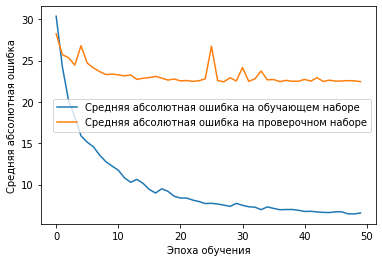

In [ ]:
# Предсказываем по предыдущей работе и желаемой
modelTProf = Sequential()

modelTProf.add(Dense(256, activation='relu', input_dim=(xTrainProf01.shape[1]) ) )  # Было Relu
# modelTProf.add(BatchNormalization()) # Обучение и остановка за 10 эпох. Потом переобучение
modelTProf.add(Dense(128, activation='relu')) # Вообще не было.
modelTProf.add(Dense(256, activation='relu')) # Было 500. Но лучше 256
modelTProf.add(Dense(256, activation='relu')) # Вообще не было

modelTProf.add(Dense(128, activation='relu')) # Вообще не было.
modelTProf.add(Dense(128, activation='relu')) # Вообще не было.

modelTProf.add(Dense(1, activation='linear'))

modelTProf.compile(optimizer=Adagrad(lr=1e-2), loss='mse', metrics=['mae']) # было 1e-3. Но 1e-2 лучше

history = modelTProf.fit(xTrainProf01[:50000],
                    yTrain[:50000],
                    batch_size=20,   # Было 20 и это было хорошо, но долго
                    epochs=50,
                    #validation_split=0.2,
                    validation_data=(xTrainProf01[50000:], yTrain[50000:]),
                    verbose=1, shuffle=True)

plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

# 9 Создание тренеровчной выборки для нейросети № 3

*(опыт работы (текстовые данные))*

In [ ]:
# Выкачиваем данные по резюме
def getXTrainTRez(values):
  xTrainTRez = []

  for val in values:
    currText = ""
    if (type(val[6]) != float):
      currText += val[6]

    if (getParameterSalary(val[1]) != -1):
      xTrainTRez.append(currText)

  xTrainTRez = np.array(xTrainTRez)

  return xTrainTRez

In [ ]:
# Вытаскиваем резюме для выборки
xTrainTRez = getXTrainTRez(fixed_df.values)

In [ ]:
print(xTrainTRez[10]) # Пример профессии 11го резюме

Опыт работы 27 лет 4 месяца  Программист 2 000 EUR Информационные технологии, интернет, телеком Программирование, Разработка Системная интеграция Занятость: полная занятость График работы: полный день Опыт работы 27 лет 4 месяца Январь 2008 — по настоящее время 11 лет 4 месяца Консалтинг КАС Главный аналитик Программирование на разных версиях RPG для AS/400 (iSeries). Модификация и доработка существующего кода, расширения функциональности системы. Разработка новых модулей и подсистем. Постановка задач, управление проектами. Январь 1993 — Январь  2008 15 лет 1 месяц Артекс, крупнейший дилер БМВ в Москве Директор по ИТ Доработка существующей системы управления дилерским предприятием (AS/400, iSeries). Все версии RPG (RPG36, RPG400, ILE RPG). Работа с DB2. Расширение функциональности системы, изменение системы, согласно действующему законодательству РФ. Руководство проектами, координация действий различных подразделений компании и сторонних организаций. Бюджетирование. Исследование бизнес

In [ ]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount_3 = 5000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount_3, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainTRez)         # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainRezIndexes = tokenizer.texts_to_sequences(xTrainTRez) # Обучающие тесты в индексы

In [ ]:
xTrainRez01 = tokenizer.sequences_to_matrix(xTrainRezIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainRez01.shape)                                      # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainRez01[0][0:100])

(62967, 5000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0.]


In [ ]:
print(xTrainRez01.shape) # Размер выборки самых частых слов
print(xTrainRez01[555]) # Пример из отформатированной выборки

(62967, 5000)
[0. 0. 1. ... 0. 0. 0.]


# 10 Эксперименты с нейрометью № 3

Epoch 1/20
250/250 [==============================] - 1s 5ms/step - loss: 16224.4365 - mae: 31.0786 - val_loss: 1580.4927 - val_mae: 25.4823
Epoch 2/20
250/250 [==============================] - 1s 4ms/step - loss: 14813.9062 - mae: 24.5501 - val_loss: 2778.7988 - val_mae: 40.0932
Epoch 3/20
250/250 [==============================] - 1s 4ms/step - loss: 19309.7207 - mae: 26.0390 - val_loss: 1555.7543 - val_mae: 24.4949
Epoch 4/20
250/250 [==============================] - 1s 4ms/step - loss: 14077.8564 - mae: 21.1239 - val_loss: 1785.0229 - val_mae: 26.8201
Epoch 5/20
250/250 [==============================] - 1s 4ms/step - loss: 11428.9561 - mae: 23.2189 - val_loss: 1290.2317 - val_mae: 22.3554
Epoch 6/20
250/250 [==============================] - 1s 4ms/step - loss: 9259.4033 - mae: 21.9895 - val_loss: 1406.8309 - val_mae: 23.2753
Epoch 7/20
250/250 [==============================] - 1s 4ms/step - loss: 3945.9424 - mae: 18.2959 - val_loss: 1720.0972 - val_mae: 24.7408
Epoch 8/20
250/

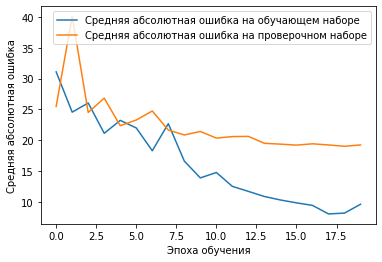

In [ ]:
# здесь в параметрах maxWordCount = 2000
maxWordCount = 2000

modelTRez = Sequential()

modelTRez.add(Dense(256, activation='relu',input_dim=(xTrainRez01.shape[1])))
modelTRez.add(Dense(128, activation='relu'))
modelTRez.add(Dense(256, activation='relu'))
modelTRez.add(Dense(256, activation='relu'))

modelTRez.add(Dense(128, activation='relu'))
modelTRez.add(Dense(128, activation='relu'))

modelTRez.add(Dense(1, activation='linear'))

modelTRez.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])

history = modelTRez.fit(xTrainRez01[:50000],
                    yTrain[:50000],
                    batch_size=200,
                    epochs=20,
                    validation_data=(xTrainRez01[50000:], yTrain[50000:]),
                    verbose=1, shuffle=True)

plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

# 11 Создание и обучение составной нейронной сети

*(с учётом проведённых на составных частях экспериментов)*

Epoch 1/50
1563/1563 [==============================] - 10s 6ms/step - loss: 15601.3213 - mae: 26.3967 - val_loss: 1434.5361 - val_mae: 23.0212
Epoch 2/50
1563/1563 [==============================] - 9s 6ms/step - loss: 15137.5986 - mae: 23.1597 - val_loss: 1313.4753 - val_mae: 22.2019
Epoch 3/50
1563/1563 [==============================] - 9s 6ms/step - loss: 14927.8877 - mae: 19.5452 - val_loss: 3874.4604 - val_mae: 44.0499
Epoch 4/50
1563/1563 [==============================] - 9s 6ms/step - loss: 14075.2803 - mae: 19.1005 - val_loss: 1286.6373 - val_mae: 23.2553
Epoch 5/50
1563/1563 [==============================] - 9s 6ms/step - loss: 13804.6992 - mae: 19.4255 - val_loss: 1144.0177 - val_mae: 20.8405
Epoch 6/50
1563/1563 [==============================] - 9s 6ms/step - loss: 14968.4521 - mae: 16.9024 - val_loss: 1157.9963 - val_mae: 21.1128
Epoch 7/50
1563/1563 [==============================] - 9s 6ms/step - loss: 15410.9551 - mae: 19.5923 - val_loss: 1460.6147 - val_mae: 25.931

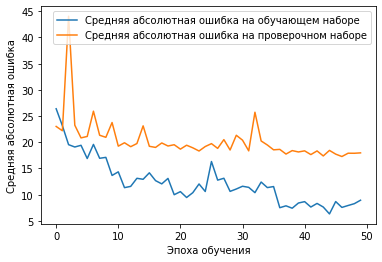

In [ ]:
input1 = Input((xTrain01.shape[1],))
input2 = Input((xTrainProf01.shape[1],))
input3 = Input((xTrainRez01.shape[1],))

x1 = BatchNormalization()(input1) # Создаем ветку х1
x1 = Dropout(0.4)(x1)
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(256, activation="relu")(x1)
x1 = Dense(128, activation = "relu")(x1)
x1 = Dense(128, activation = "relu")(x1)
x1 = Dense(1, activation = "relu")(x1)

x2 = BatchNormalization()(input2) # Создаем ветку х2
x2 = Dense(256, activation="relu")(input2)
x2 = Dense(128, activation="relu")(x2)
#x2 = Dropout(0.3)(x2)
x2 = Dense(256, activation = "relu")(x2)
#x2 = Dropout(0.3)(x2)
x2 = Dense(256, activation = "relu")(x2)
x2 = Dense(128, activation = "relu")(x2)
x2 = Dense(128, activation = "relu")(x2)

x3 = BatchNormalization()(input3) # Создаем ветку х3
x3 = Dense(256, activation= "relu")(input3)
x3 = Dense(128, activation = "relu")(x3)
#x3 = Dropout(0.3)(x3)
x3 = Dense(256, activation = "relu")(x3)
#x3 = Dropout(0.3)(x3)
x3 = Dense(255, activation = "relu")(x3)
x3 = Dense(128, activation = "relu")(x3)
x3 = Dense(128, activation = "relu")(x3)

x = concatenate([x1, x2, x3]) # Объединяем все три ветки

x = Dense(64, activation='relu')(x)   # не было вообще
x = Dense(64, activation='linear')(x)   # было 15
#x = Dropout(0.4)(x)
x = Dense(1, activation='linear')(x) # Финальный нейрон, делает регрессию. Было relu !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

model = Model((input1, input2, input3), x) # В Model загружаем стартовые и последнюю точки

model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])

history = model.fit([xTrain01[:50000], xTrainProf01[:50000], xTrainRez01[:50000]],
                    yTrain[:50000],
                    epochs= 50,
                    validation_data=([xTrain01[50000:], xTrainProf01[50000:], xTrainRez01[50000:]],
                    yTrain[50000:]),
                    verbose=1, shuffle=True)

plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

# 12 Результаты

Подготовлены три нейронные сети предназначанные для анализа отдельных сведений базы данных hh.ru.

В результате экспериментов с изменением различных параметров нейронных сетей (количество и состав слоёв, активационных функций, отношения обучающих и проверочных выборок, шаги обучения) удалось добиться уменьшения значений отклонений:

1) в первой нейросети (анализ "простых" данных) - с 34,9 тыс. руб. до 30,6 тыс. руб.;

2) во второй нейросети (анализ "простых текстовых" данных) - с 32,0 тыс. руб. до  22,4 тыс. руб.;

3) в третьей нейросети (анализ "сложных текстовых" данных) - с 23,7 тыс. руб. до 19,2 тыс. руб.

Применение полученных результатов (параметров нейронных сетей) в составной нейронной сети не привело к значительному уменьшению значения ошибки.

# 13 Выводы

Создана и обучена составная нейронная сеть, предназначенная для предсказания размера заработной платы, которую запросит соискатель, на основании сведений о соискателе.

Проверена гипотеза о построении составной нейронной сети, основанной на параметрах составных частей, при которых достигаются наилучшие результаты обучения составных частей. Использование составной нейронной сети не привело к получению лучших результатов работы (значительном уменьшению ошибки).

Поставленная цель достигнута.

Для уменьшения размера ошибки представляется целесобразным продолжение дальнейших экспериментов:

- на составной нейронной сети (не на составных частях по отдельности);

- в более стабильной среде разработки (при обучении нейронной сети использовались ресурсы по подписке Colab Pro, не обеспечивающие стабильной работы).